# Xarray + Cloud OISST (One-Month) Basics & Stats

ATMS 523 - Deffi Putri

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [1]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3? \
Answer: engine  = h5netcdf
2. Why do we need `storage_options={'anon': True}`? \
Answer: because AWS data is open for public so we don't need credentials
3. Inspect dataset attributes: what are the units and long name of `sst`? \
Answer: \
long_name : Daily sea surface temperature \
units : Celsius


In [2]:
yearmonth = "201507"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 31 files for 201507. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/201507/oisst-avhrr-v02r01.20150701.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/201507/oisst-avhrr-v02r01.20150702.nc']


<xarray.Dataset> Size: 514MB
Dimensions:  (time: 31, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 248B 2015-07-01T12:00:00 ... 2015-07-31T12...
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/38)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    Description:                Reynolds, et al.(2007) Daily High-resolution ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20150701.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space? \
Answer: time name: 'time', x and y coordinates: 'lat and lon', height coordinate: 'zlev'
2. What is the shape of `sst`? \
Answer: Shape Array (whole data): 31, 1, 720, 1440 \
Shape for each chunk: 1, 1, 720, 1440
3. How are missing values represented? \
Answer : since the data was opened with xarray mask_and_scale=True then the missing value is represented by NaN


In [5]:
list(ds.data_vars), list(ds.coords)

(['anom', 'err', 'ice', 'sst'], ['lat', 'lon', 'time', 'zlev'])

## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose? \
Answer: Hindian ocean in the south of Indonesia (latitude: 5 to 18 south, longitude: 100 to 120 east)
2. How many daily steps are present in this month? \
Answer: There are 31 daily step in July 2015


In [15]:
var = "sst"

lon_min, lon_max = 100, 120   # TODO
lat_min, lat_max =  -18, -5   # TODO

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 52, lon: 80)> Size: 516kB
dask.array<getitem, shape=(31, 1, 52, 80), dtype=float32, chunksize=(1, 1, 52, 80), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 208B -17.88 -17.62 -17.38 ... -5.625 -5.375 -5.125
  * lon      (lon) float32 320B 100.1 100.4 100.6 100.9 ... 119.4 119.6 119.9
  * time     (time) datetime64[ns] 248B 2015-07-01T12:00:00 ... 2015-07-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation? \
Answer:\
Month mean SST (°C): 26.972408294677734 \
Month std SST (°C): 0.20926322042942047
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies? \
Answer: \
Max anomaly (°C): 0.4251781702041626 \
Min anomaly (°C): -0.3842056393623352
3. What day had the warmest/coolest region-mean SST? \
Answer:(in celcius) \
Warmest day: 2015-07-01 27.3975887298584 \
Coolest day: 2015-07-09 26.58820343017578


Month mean SST (°C): 26.972408294677734
Month std SST (°C): 0.20926322042942047


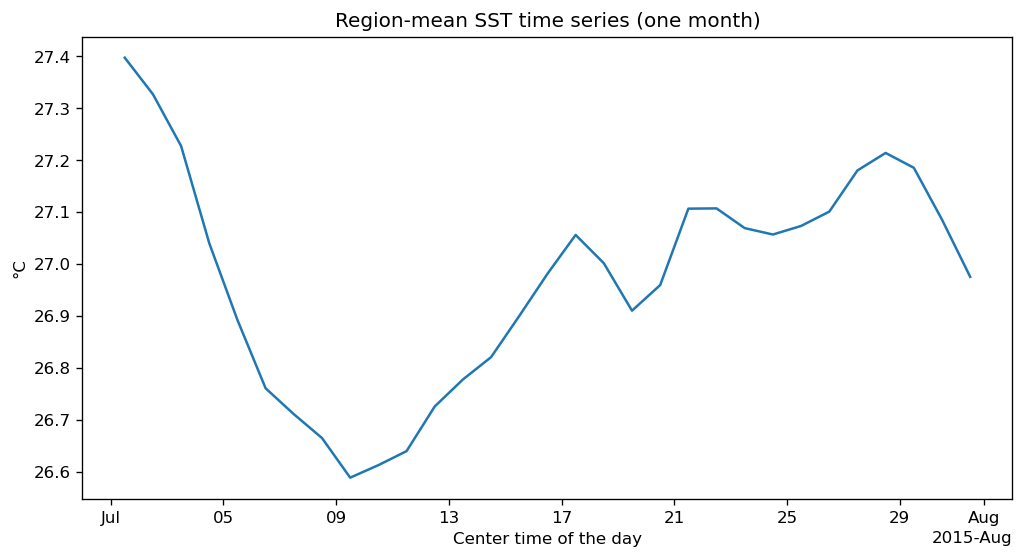

Warmest day: 2015-07-01 27.3975887298584
Coolest day: 2015-07-09 26.58820343017578


/tmp/ipykernel_1278083/217981507.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
/tmp/ipykernel_1278083/217981507.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


In [19]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))

print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 0.4251781702041626
Min anomaly (°C): -0.3842056393623352


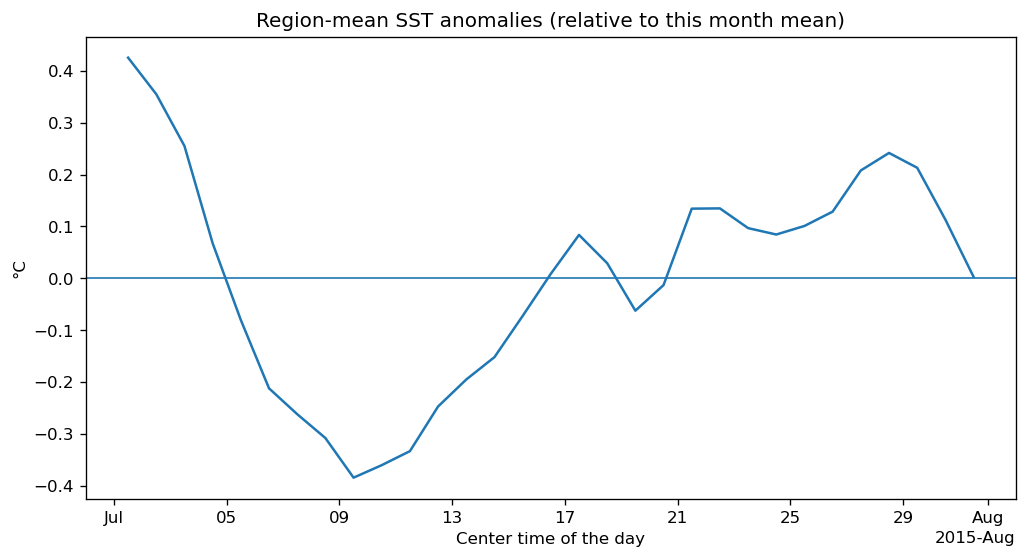

In [18]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice? \
Answer: Mean SSt shows a north-south gradient: warmer water in the north and cooler waters further south
2. Where is variability strongest? \
Answer: According to maps of standard deviation and sst range, the strongest variability occurs south of the island (Java island) where the std deviation exceed 1 degree celcius with sst range greater than 3 celcius

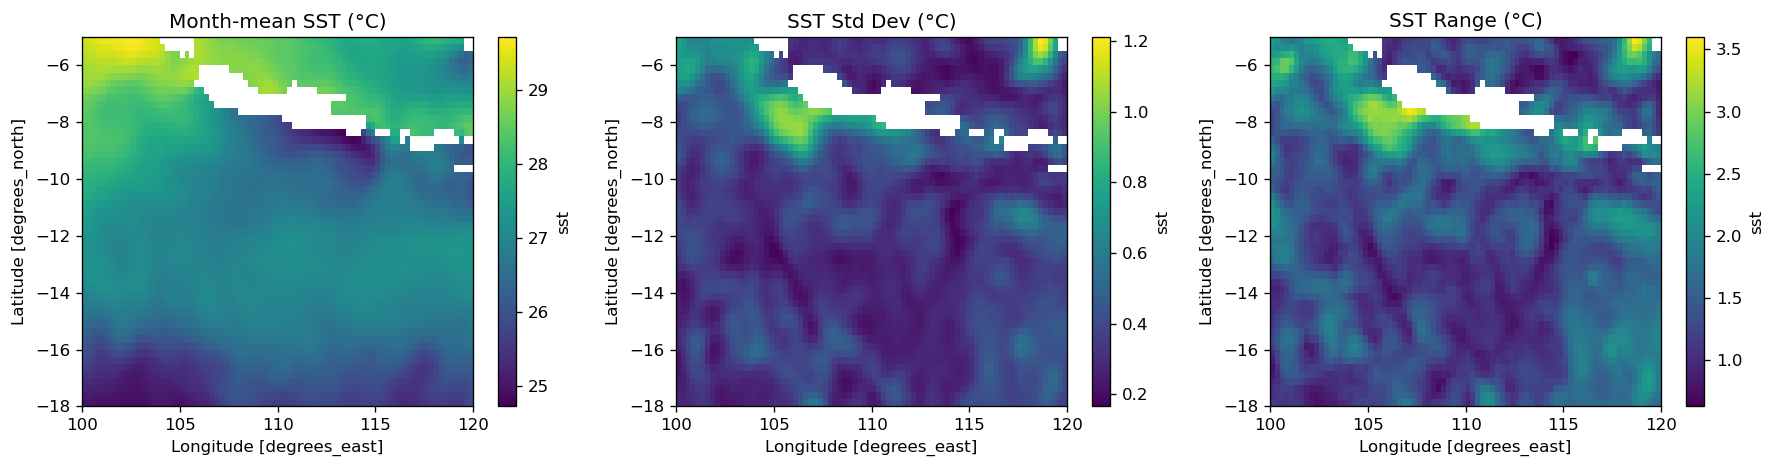

In [20]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [22]:
ds_regional = xr.Dataset(
    {
        "regional_mean_ts": ts,
        "month_mean": mean_sst,
        "month_std": std_sst,
        "month_range": range_sst
    }
)

ds_regional.to_netcdf("/data/keeling/a/deffip2/ATMS_523/HW_2_Module_2/module-2-check-in-deffip2/ATMS523_Mod2_sst_regional.nc")